# We will use a machine learning framwork named pytorch
## following this [tutorial](https://youtu.be/tHL5STNJKag?si=TgT5kABIFReWEcbD)
## I dont actually understand what any of this stuff does

### I later found out that you have to install pytorch like this for it to access your GPU
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [84]:
# imports based on the tutorial
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print(torch.cuda.is_available()) # this checks weathers the GPU can be used

True


In [85]:
class ChestXrayDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

  @property
  def classes(self):
    return self.data.classes

In [86]:
dataset = ChestXrayDataset('ChestXRayDataset')

In [87]:
len(dataset)

5840

0 healthy   1 pneumonia

In [88]:
image, label = dataset[1575]
print(label)
# image

1


In [89]:
transform = transforms.Compose([
    # no need to resize images
    transforms.Resize((250, 250)),
    transforms.ToTensor()
])

dataset = ChestXrayDataset('ChestXRayDataset', transform=transform)

In [90]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## delete code under?

In [91]:
for images, labels in dataloader:
    pass

# the model

In [95]:
class ChestXrayModel(nn.Module):

    def __init__(self, num_classes=2): # only 2 classes (healthy or pneumonia)
        super(ChestXrayModel, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        enet_out_size = 1280
        self.classifier = nn.Linear(enet_out_size, num_classes)
        pass

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [97]:
model = ChestXrayModel(num_classes=2)

In [98]:
model(images)

tensor([[-4.1437e-04, -2.4931e-01],
        [-2.2407e-03, -4.7510e-01],
        [-6.4712e-02, -3.3360e-01],
        [ 1.5990e-03,  5.0466e-02],
        [-2.5450e-02, -3.6097e-01],
        [ 1.2538e-01,  7.3892e-02],
        [-1.7582e-01, -8.0802e-02],
        [-1.1431e-01, -2.2384e-01],
        [-1.6026e-01, -3.0034e-01],
        [ 9.5681e-02, -1.2322e-01],
        [-2.4213e-02, -9.6457e-02],
        [ 2.1188e-01, -7.0773e-02],
        [-9.0200e-02, -1.0188e-01],
        [-8.0005e-02, -8.7548e-02],
        [-2.0413e-01,  8.8927e-02],
        [ 3.2620e-02, -8.4296e-02]], grad_fn=<AddmmBackward0>)

# splitting the data into 3 datasets (DONT RUN THIS)

In [99]:
# import splitfolders

# input_folder = "ChestXrayDataset"
# output_folder = "splitted_data"

# splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.7, 0.15, 0.15))

# creating the training loop 

In [100]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [101]:
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor()
])


train_dataset = ChestXrayDataset('splitted_data/train', transform=transform)
val_dataset   = ChestXrayDataset('splitted_data/val',   transform=transform)
test_dataset  = ChestXrayDataset('splitted_data/test',  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [104]:
num_epochs = 5
train_losses, val_losses = [], []

model = ChestXrayModel(num_classes=2)
model.to(device)

#
#
# training
#
#
for epoch in range(num_epochs):
    model.train() # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

#
#
# validation
#
#
    model.eval() # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

Validation loop:   0%|          | 0/28 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/28 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/28 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/28 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/28 [00:00<?, ?it/s]

# TODO: Visualize losses

# TODO: Evaluate the results

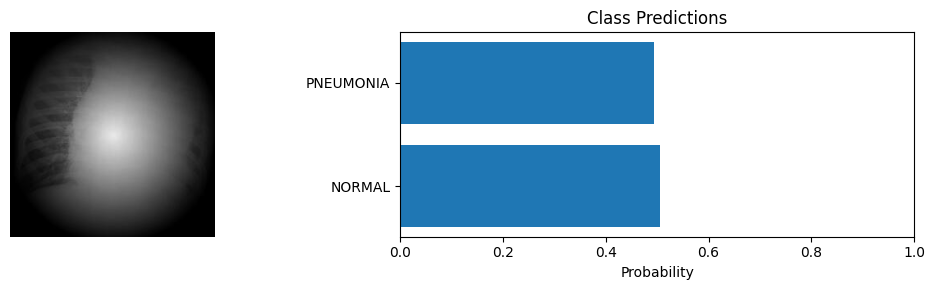

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(11, 3))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "splitted_data\\test\\NORMAL\\xray_n_055.jpeg"
test_image = "splitted_data\\test\\PNEUMONIA\\xray_P_4201.jpeg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)